# Binary Classification with JAX and Keras

In this notebook you should recreate the logstic regression from the first notebook but this time use the autodiff framework of JAX and keras

In [31]:
import platform
import subprocess
import os
from datetime import datetime

# --- JAX ---
import jax
import jax.numpy as jnp

# --- NumPy ---
import numpy as np

# --- PyTorch ---
import torch

# --- Keras 3 ---
os.environ["KERAS_BACKEND"] = "torch"   # or "jax", depending on usage
import keras

print("=== Python & OS Info ===")
print("Date: {}".format(datetime.now()))
print(f"Python version:      {platform.python_version()}")
print(f"System:              {platform.system()}")
print(f"Machine:             {platform.machine()}")             # arm64 on Apple Silicon
print(f"Processor:           {platform.processor()}")
print(f"Mac version:         {platform.mac_ver()[0]}")           # macOS version
print()
# Optionally: Detect Apple chip
def get_chip_info():
    try:
        out = subprocess.check_output(
            ["sysctl", "-n", "machdep.cpu.brand_string"]
        ).decode().strip()
        return out
    except Exception:
        return "unknown"

print(f"Chip:          {get_chip_info()}")
print()

print("=== JAX Info ===")
print(f"JAX version:         {jax.__version__}")
print(f"JAX devices:         {jax.devices()}")
print()

print("=== PyTorch Info ===")
print(f"PyTorch version:     {torch.__version__}")
print(f"CUDA available:      {torch.cuda.is_available()}")
print(f"Device:              {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
print()

print("=== NumPy & Keras ===")
print(f"NumPy version:       {np.__version__}")
print(f"Keras version:       {keras.__version__}")
print(f"Keras backend:       {keras.config.backend()}")

=== Python & OS Info ===
Date: 2025-12-29 22:11:49.846158
Python version:      3.11.0
System:              Windows
Machine:             AMD64
Processor:           AMD64 Family 23 Model 104 Stepping 1, AuthenticAMD
Mac version:         

Chip:          unknown

=== JAX Info ===
JAX version:         0.8.2
JAX devices:         [CpuDevice(id=0)]

=== PyTorch Info ===
PyTorch version:     2.9.1+cpu
CUDA available:      False
Device:              cpu

=== NumPy & Keras ===
NumPy version:       2.3.5
Keras version:       3.13.0
Keras backend:       torch


### Generate training data

In [32]:
import numpy as np

def generate_training_data(ntrain=200, scale=6.0, seed=None):
    """
    Reproduce the training data (x2, y0) from 01_mlp.ipynb.

    - 2D inputs start uniform on [0, scale]^2
    - Then mapped into four quadrants
    - Labels: quadrants I & III -> 1, quadrants II & IV -> 0
    - Final features x2 are sigmoid-transformed coordinates (perzeptron with w = I, b = 0)
    """
    rng = np.random.default_rng(seed)

    # 2d-Inputs (this is x0 in the notebook)
    x0 = rng.random((ntrain, 2))
    x0 *= scale

    # Quadrant manipulation exactly as in the notebook
    q = ntrain // 4

    # indices [q : 2q): flip x -> quadrant II
    x0[q:2*q, 0] *= -1.0

    # indices [2q : 3q): flip y -> quadrant IV
    x0[2*q:3*q, 1] *= -1.0

    # indices [3q : ntrain): flip both -> quadrant III
    x0[3*q:, :] *= -1.0

    # labels (y0 in the notebook)
    y0 = np.ones(ntrain, dtype=float)
    y0[q:2*q] = 0.0        # quadrant II
    y0[2*q:3*q] = 0.0      # quadrant IV
    # first q and last q remain 1.0 (quadrants I & III)

    # Perzeptron transform with w = I, b = 0 -> this is x2 in the notebook
    def sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    x2 = sigmoid(x0)

    return x2, y0

# In the first notebook a scale of 6.0 was used, here we use 1.0
x2, y0 = generate_training_data(ntrain=200, scale=6.0, seed=42)

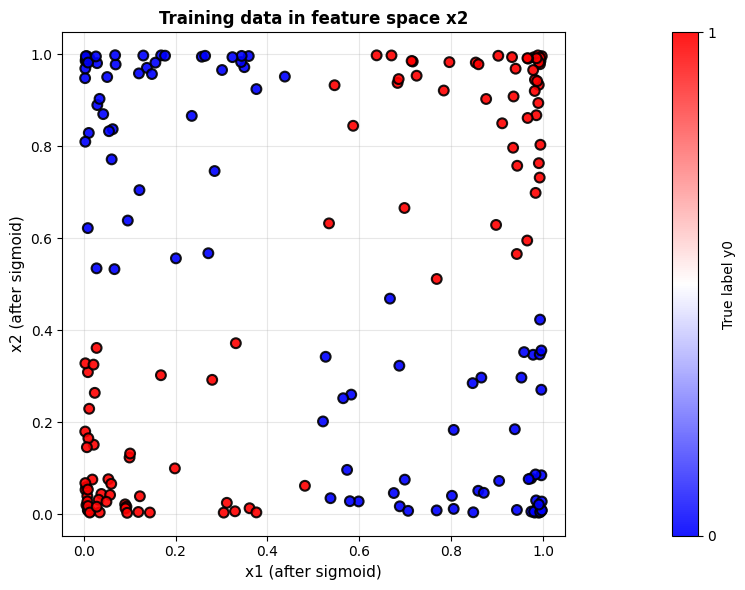

In [33]:
import matplotlib.pyplot as plt

def plot_data_and_probability(x, y, params=None, predict_proba_func=None, figsize=(8, 6)):
    """
    Plot training data and optionally forecasted probability.

    Parameters:
    -----------
    x : array-like, shape (n_samples, 2)
        Training data features
    y : array-like, shape (n_samples,)
        Training data labels (0 or 1)
    params : dict, optional
        Model parameters. If None, only data is plotted.
    predict_proba_func : callable, optional
        Function to predict probabilities: predict_proba_func(params, x)
        Required if params is not None.
    figsize : tuple, optional
        Figure size (default: (8, 6))
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Create a grid for probability contours (if model is provided)
    if params is not None and predict_proba_func is not None:
        x1_min, x1_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
        x2_min, x2_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
        xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                               np.linspace(x2_min, x2_max, 100))
        grid_points = np.c_[xx1.ravel(), xx2.ravel()]

        # Predict probabilities on the grid
        proba_grid = predict_proba_func(params, grid_points)
        proba_grid = np.array(proba_grid).reshape(xx1.shape)

        # Plot probability contours (reversed colormap: red = high prob for class 1)
        contour = ax.contourf(xx1, xx2, proba_grid, levels=20, cmap='RdYlBu_r', alpha=0.6)
        cbar1 = plt.colorbar(contour, ax=ax)
        cbar1.set_label('Forecasted probability p(y=1|x)', fontsize=10)

        # Add decision boundary (p=0.5)
        contour_lines = ax.contour(xx1, xx2, proba_grid, levels=[0.5], colors='black',
                                   linewidths=2, linestyles='--', zorder=5)
        ax.clabel(contour_lines, inline=True, fontsize=10, fmt='p=0.5')

        title = 'Training Data and Forecasted Probability'
    else:
        title = 'Training data in feature space x2'

    # Plot training data points
    scatter = ax.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr',
                         edgecolor='k', linewidth=1.5, s=50, alpha=0.9, zorder=10)
    cbar2 = plt.colorbar(scatter, ax=ax, ticks=[0, 1], pad=0.15)
    cbar2.set_label('True label y0', fontsize=10)

    ax.set_xlabel('x1 (after sigmoid)', fontsize=11)
    ax.set_ylabel('x2 (after sigmoid)', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the training data
plot_data_and_probability(x2, y0)

# Start of your code

## a) Logistic Regression with JAX

Please implement the logistic regression model and the negative log-likelihood loss function using JAX. Think of jax as a numpy replacement, with autodifferentiation. You can use the following code as a starting point.

Step 0, Loss: 0.6978
Step 200, Loss: 0.6929
Step 400, Loss: 0.6929
Step 600, Loss: 0.6929
Step 800, Loss: 0.6929
Step 1000, Loss: 0.6929
Step 1200, Loss: 0.6929
Step 1400, Loss: 0.6929
Step 1600, Loss: 0.6929
Step 1800, Loss: 0.6929


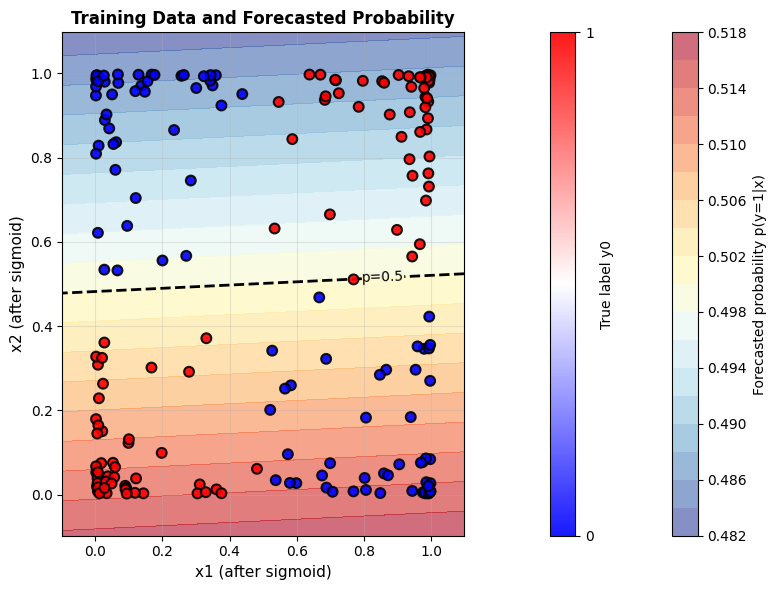

In [34]:
# ------------------------------------------------------------
# Parameter initialization (fully implemented)
# ------------------------------------------------------------
def init_params(seed=0):
    """
    Initialize parameters for logistic regression.

    Returns a dictionary:
        params = {
            "w": w,   # shape (2,)
            "b": b    # scalar
        }
    """
    key = jax.random.PRNGKey(seed)
    # Random initialization for weights (small values)
    w = 0.1 * jax.random.normal(key, (2,))
    # Bias initialized to zero
    b = jnp.array(0.0)
    return {"w": w, "b": b}


# ------------------------------------------------------------
# Model: p(y = 1 | x) given the parameters
# ------------------------------------------------------------
def predict_proba(params, x):
    """
    Compute p(y = 1 | x).
    """
    w = params["w"]
    b = params["b"]

    z = jnp.dot(x, w) + b
    pred = jax.nn.sigmoid(z)
    return pred



# ------------------------------------------------------------
# Negative Log-Likelihood loss
# ------------------------------------------------------------
def nll_loss(params, x, y):
    """
    Binary cross-entropy / negative log-likelihood.
    """
    y_pred = predict_proba(params, x)

    # Binary cross-entropy (same formula as Keras uses)
    eps = 1e-7
    y_pred = jnp.clip(y_pred, eps, 1 - eps)
    loss = -jnp.mean(y * jnp.log(y_pred) + (1 - y) * jnp.log(1 - y_pred))

    return loss

# ------------------------------------------------------------
# Full-batch gradient descent training loop
# ------------------------------------------------------------
def train(x, y, lr=0.5, n_steps=2000):
    """
    Full-batch gradient descent training.

    TODO:
      - Initialize params = init_params()
      - Define grad_loss = jax.grad(nll_loss)
      - Loop over steps:
          * compute gradients
          * update w and b
      - Print loss every 200 steps (optional)
      - Return final params
    """
    params = init_params()
    grad_loss = jax.grad(nll_loss)

    for step in range(n_steps):
        grads = grad_loss(params, x, y)

        params = {
            "w": params["w"] - lr * grads["w"],
            "b": params["b"] - lr * grads["b"]
        }
        if step % 200 == 0:
            current_loss = nll_loss(params, x, y)
            print(f"Step {step}, Loss: {current_loss:.4f}")
    return params


# ------------------------------------------------------------
# After students implement everything:
params = train(x2, y0)
# ------------------------------------------------------------
# Plot the data and forecasted probability
plot_data_and_probability(x2, y0, params, predict_proba)

## b) Make multi-layer perceptron
Add a hidden layer of dimension 16 to the model and redo a). To improve the performance, use jit by putting the update step in a jit function.
```python
@jax.jit
def update(params, x, y, lr):
    grads = jax.grad(nll_loss)(params, x, y)
    return {
        "W1": params["W1"] - lr * grads["W1"],
        # YOUR CODE HERE
        }
```

Step 0, Loss: 0.6929
Step 200, Loss: 0.1892
Step 400, Loss: 0.1275
Step 600, Loss: 0.1186
Step 800, Loss: 0.1155
Step 1000, Loss: 0.1140
Step 1200, Loss: 0.1129
Step 1400, Loss: 0.1116
Step 1600, Loss: 0.1093
Step 1800, Loss: 0.1042


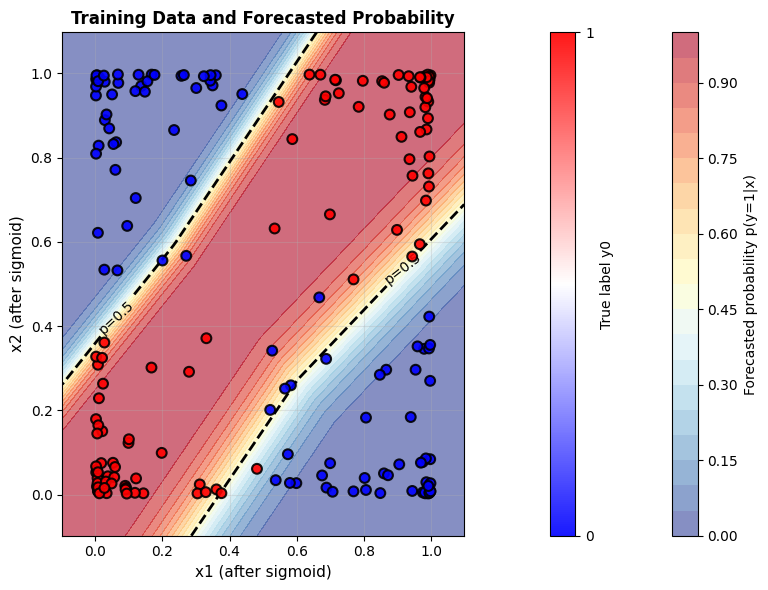

In [35]:
# ------------------------------------------------------------
# Parameter initialization for MLP (fully implemented)
# ------------------------------------------------------------
def init_params_mlp(seed=0, input_size=2, hidden_size=16):
    """
    Initialize parameters for MLP with one hidden layer.

    Returns a dictionary:
        params = {
            "W1": W1,   # shape (2,16)
            "b1": b1    # shape (16,)
            "W2": W2,   # shape (16,)
            "b2": b2    # scalar
        }
    """
    key = jax.random.PRNGKey(seed)
    key1, key2 = jax.random.split(key)
    # Random initialization for weights (small values)
    W1 = 0.1 * jax.random.normal(key1, (input_size, hidden_size))
    # Bias initialized to zero
    b1 = jnp.zeros(hidden_size)
    W2 = 0.1 * jax.random.normal(key2, (hidden_size,))
    b2 = jnp.array(0.0)

    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

# ------------------------------------------------------------
# Model: p(y = 1 | x) given the parameters
# ------------------------------------------------------------
def predict_proba_mlp(params, x):
    """
    Compute p(y = 1 | x).
    """
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]

    z1 = (jnp.dot(x, W1) + b1)
    z1_act = jax.nn.relu(z1)

    z2 = jnp.dot(z1_act, W2) + b2
    pred = jax.nn.sigmoid(z2)
    return pred

# ------------------------------------------------------------
# Negative Log-Likelihood loss
# ------------------------------------------------------------
def nll_loss(params, x, y):
    """
    Binary cross-entropy / negative log-likelihood.
    """
    y_pred = predict_proba_mlp(params, x)

    # Binary cross-entropy (same formula as Keras uses)
    eps = 1e-7
    y_pred = jnp.clip(y_pred, eps, 1 - eps)
    loss = -jnp.mean(y * jnp.log(y_pred) + (1 - y) * jnp.log(1 - y_pred))

    return loss

@jax.jit
def update(params, x, y, lr):
    grads = jax.grad(nll_loss)(params, x, y)
    return {
        "W1": params["W1"] - lr * grads["W1"],
        "b1": params["b1"] - lr * grads["b1"],
        "W2": params["W2"] - lr * grads["W2"],
        "b2": params["b2"] - lr * grads["b2"]
    }


# ------------------------------------------------------------
# Full-batch gradient descent training loop
# ------------------------------------------------------------
def train_mlp(x, y, lr=0.5, n_steps=2000):
    """
    Full-batch gradient descent training.
    """
    params = init_params_mlp()

    for step in range(n_steps):

        params = update(params, x, y, lr)
        if step % 200 == 0:
            current_loss = nll_loss(params, x, y)
            print(f"Step {step}, Loss: {current_loss:.4f}")
    return params

x2, y0 = generate_training_data(ntrain=200, scale=6.0, seed=42)
# ------------------------------------------------------------
# After students implement everything:
params_mlp = train_mlp(x2, y0)
# ------------------------------------------------------------
# Plot the data and forecasted probability
plot_data_and_probability(x2, y0, params_mlp, predict_proba_mlp)

## c) Implement the MLP in Keras 

Implement the MLP in Keras using the sequential API. 

In [36]:
def plot_data_and_probability(x, y, model=None, figsize=(8, 6)):
    """
    Plot training data and optionally forecasted probability.

    Parameters:
    -----------
    x : array-like, shape (n_samples, 2)
        Training data features
    y : array-like, shape (n_samples,)
        Training data labels (0 or 1)
    model : keras.Model, optional
        Trained Keras model. If None, only data is plotted.
    figsize : tuple, optional
        Figure size (default: (8, 6))
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Create a grid for probability contours
    if model is not None:
        x1_min, x1_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
        x2_min, x2_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
        xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                               np.linspace(x2_min, x2_max, 100))
        grid_points = np.c_[xx1.ravel(), xx2.ravel()]

        # Predict probabilities on the grid
        proba_grid = model.predict(grid_points, verbose=0).flatten()
        proba_grid = np.array(proba_grid).reshape(xx1.shape)

        # Plot probability contours (reversed colormap: red = high prob for class 1)
        contour = ax.contourf(xx1, xx2, proba_grid, levels=20, cmap='RdYlBu_r', alpha=0.6)
        cbar1 = plt.colorbar(contour, ax=ax)
        cbar1.set_label('Forecasted probability p(y=1|x)', fontsize=10)

        # Add decision boundary (p=0.5)
        contour_lines = ax.contour(xx1, xx2, proba_grid, levels=[0.5], colors='black',
                                   linewidths=2, linestyles='--', zorder=5)
        ax.clabel(contour_lines, inline=True, fontsize=10, fmt='p=0.5')

        title = 'Training Data and Forecasted Probability'
    else:
        title = 'Training data in feature space x2'

    # Plot training data points
    scatter = ax.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr',
                         edgecolor='k', linewidth=1.5, s=50, alpha=0.9, zorder=10)
    cbar2 = plt.colorbar(scatter, ax=ax, ticks=[0, 1], pad=0.15)
    cbar2.set_label('True label y0', fontsize=10)

    ax.set_xlabel('x1 (after sigmoid)', fontsize=11)
    ax.set_ylabel('x2 (after sigmoid)', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

c:\Data\003_University\002_Kurse\A_Semester_MSI\004_DL\msi-dl\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 0, Loss: 0.7240
Step 200, Loss: 0.1349
Step 400, Loss: 0.0678
Step 600, Loss: 0.0479
Step 800, Loss: 0.0377
Step 1000, Loss: 0.0313
Step 1200, Loss: 0.0270
Step 1400, Loss: 0.0239
Step 1600, Loss: 0.0216
Step 1800, Loss: 0.0198
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67 (268.00 B)

 Trainable params: 65 (260.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (8.00 B)

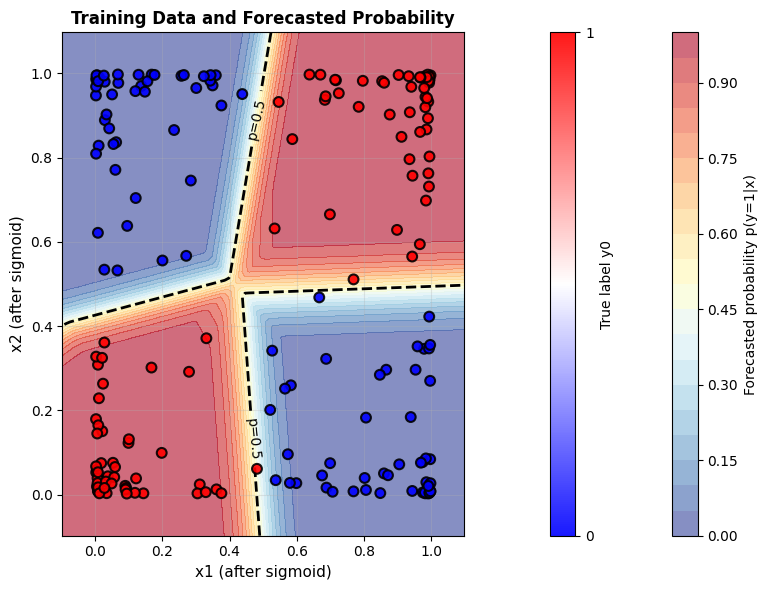

In [37]:
# Create the model
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(2,)),    # Hidden layer: 2 -> 16
    keras.layers.Dense(1, activation='sigmoid')                     # Output layer: 16 -> 1
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.5),
    loss='binary_crossentropy',                          # Same as nll_loss
    metrics=['accuracy']
)

x2, y0 = generate_training_data(ntrain=200, scale=6.0, seed=42)
# Train the model
history = model.fit(
    x2, y0,
    epochs=2000,
    batch_size=len(x2),  # Full-batch gradient descent
    verbose=0            # Set to 1 to see progress, 2 for one line per epoch
)

# Print loss every 200 steps (epochs)
for epoch in range(0, 2000, 200):
    if epoch < len(history.history['loss']):
        print(f"Step {epoch}, Loss: {history.history['loss'][epoch]:.4f}")

# Make predictions
y_pred = model.predict(x2)

# You can also view the model architecture
model.summary()

plot_data_and_probability(x2, y0, model)